In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss

In [4]:
from lightgbm import LGBMClassifier

# Table Of Contents

1. [Spling data into tranning and testing sets](#1)<br>
2. [Feature ranking with recursive feature elimination](#2)<br>
    2.1 [Helper functions](#2.1)<br>
    2.2 [Sklearn Cheat Sheet](#2.2)<br>
3. [Model 1: Logistic Regression](#3)<br>
    3.1 [Declare your Model Object](#3.1)<br>
    3.2 [Train your Model](#3.2)<br>
    3.3 [Compute Prediction](#3.3)<br>
    3.4 [Check Model Accuracy](#3.4)<br>
    3.5 [Calculating Feature Importance for Linear Regr](#3.5)<br>
    3.6 [Logistic Regression with Grid Search](#3.6)<br>
4. [Model 2: Random Forest](#4)<br>
    4.1 [Find the best combinations of hyperparameters](#4.1)<br>
    4.2 [Build, Train and Predict](#4.2)<br>
    4.3 [Evaluating RF Prediction Accuracy](#4.3)<br>
    4.4 [Plotting Feature importance for RF](#4.4)<br>
5. [Model 3: Gradient Boosting](#5)<br>
    5.1 [Build, Train and Predict](#5.1)<br>
    5.2 [Evaluating GB Prediction Accuracy](#5.2)<br>
    5.3 [Calculating Feature Importance for GB](#5.3)<br>

# Load cleaned data

In [5]:
df = pd.read_csv("datasets_clean.csv")

In [6]:
df.head()

,Unnamed: 0,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status,term
0,0,-0.299476,-0.928888,0.429087,0.890293,1.387048,-0.252133,-0.383997,-0.323443,-1.439964,1.134412,-0.220361,-0.730107,0.694300,-0.452627,-0.110954,-0.075437,0,-0.58481
1,1,1.520061,1.125154,-0.344829,-2.171730,0.620423,0.263337,1.006702,-0.323443,-0.672232,0.532558,0.167135,1.637470,-0.444565,0.617771,-0.252862,-0.437197,0,-0.58481
2,2,-0.299476,1.125154,1.053815,0.890293,0.620423,-0.666370,0.543136,-0.323443,-0.444419,-0.470533,-0.607858,0.123587,1.059815,-0.366732,1.465171,-0.075437,0,-0.58481
3,3,1.634916,-0.342019,4.690290,0.890293,1.387048,3.185782,1.470269,-0.323443,-1.439964,0.733176,-0.543275,0.533360,0.063307,0.421572,2.551702,0.648083,0,-0.58481
4,4,-0.299476,-0.635454,-0.251586,-0.640718,0.620423,-0.113177,-0.847563,-0.323443,-0.672232,0.733176,-0.801606,-1.526888,-1.906622,0.521884,-0.836013,1.371604,0,-0.58481


In [7]:
df.drop(labels=["Unnamed: 0"], axis=1, inplace=True)

## target classes:

In [8]:
target_names = list(set(df['loan_status']))
target_names

[0, 1]

In [9]:
len(df)

411273

### Explain why I reduce my data set: 
We can use weighs but for this training I would like to save time and reduce my training data set.

In [10]:
df_ = df.loc[df['loan_status']==1]
df__ = df.loc[df['loan_status']==0].iloc[0:len(df_)]
print("['loan_status']==1",len(df_)/len(df), "['loan_status']==0",len(df__)/len(df))
df = pd.concat([df_,df__])

['loan_status']==1 0.17221893973103025 ['loan_status']==0 0.17221893973103025


In [12]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths"]

target = ['loan_status']
X = df[features].values
y = df[target].values

# 1. Spling data into tranning and testing sets
<a id="1"> </a>

In [13]:
# s_fold = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [15]:
print(X_train.shape, X_test.shape)

(127492, 16) (14166, 16)


# 2. Feature ranking with recursive feature elimination
<a id="2"> </a>
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), 
the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller 
and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [16]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 12)
rfe = rfe.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
df[features].head(2)

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
5,1.586556,-0.048584,-0.009155,0.890293,-0.912826,-0.611907,1.006702,-0.323443,1.373532,-0.269915,-0.607858,1.273228,0.355719,-0.268633,0.682784,-0.798958
11,-0.783074,-1.222323,-0.755098,0.890293,0.620423,-0.686255,-0.847563,1.568027,-0.672232,-0.470533,0.037970,0.988663,0.271073,-0.466815,-0.752907,-0.798958


In [18]:
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True  True  True  True  True  True  True  True False
  True False False  True]
[1 1 5 1 1 1 1 1 1 1 1 4 1 2 3 1]


We will use the features rancked as 1

In [19]:
X_train = X_train[:,rfe.support_]
X_test = X_test[:,rfe.support_]
top_ranked_features = np.array(features)[rfe.support_].tolist()
print(top_ranked_features)

['funded_amnt', 'emp_length', 'home_ownership', 'grade', 'last_pymnt_amnt', 'mort_acc', 'pub_rec', 'int_rate', 'open_acc', 'mo_sin_rcnt_rev_tl_op', 'bc_util', 'acc_open_past_24mths']


In [20]:
print(X_train.shape, X_test.shape)

(127492, 12) (14166, 12)


In [21]:
# X = df[top_ranked_features].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [22]:
# print(X_train.shape,X_holdout.shape)

# 2.1 Helper functions
<a id="2.1"> </a>
We will use this functions to visualize the accuracy of the model and the feature importance

In [23]:
def model_acc(pred, actual):
    """
    This function gives you an accuracy report of you model and plots a confusion matrix for a classification model
    :param pred: numpy.array
    :param actual: numpy.array
    :return: pandas.DataFrame, numpy.array
    """
    report = classification_report(actual, pred)
    print(report)
    fig = plt.figure()
    cm = confusion_matrix(actual,pred).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sn.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)
    plt.show()
    return report, cm

In [24]:
def plot_feat_imp(feat_imp, features):
    """
    This function classifies the importance of the model input features and plots it
    :param feat_imp: list
    :param features: numpy.array
    :return: None
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.bar(np.arange(len(features)), feat_imp, width=0.35, color='r')
    ax.set_xticks(np.arange(len(feat_imp)))
    ax.set_xticklabels(features,rotation=90)
    plt.title('Feature Importance')
    ax.set_ylabel('Importance')

# 2.2 Sklearn Cheat Sheet
<a id="2.2"> </a>

![title](https://scikit-learn.org/stable/_static/ml_map.png)

# 3. Model 1: Logistic Regression
<a id="3"> </a>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## 3.1 Declare your Model Object
<a id="3.1"> </a>

In [25]:
lr=LogisticRegression(C=0.01,tol=0.0001,random_state=51,n_jobs=-1,solver='liblinear',
                          class_weight='balanced', multi_class ='ovr')

## 3.2 Train your Model
<a id="3.2"> </a>

In [26]:
lr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=51,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 3.3 Compute Prediction
<a id="3.3"> </a>

In [27]:
lr_y_test_pred =lr.predict(X_test)

## 3.4 Check Model Accuracy
<a id="3.4"> </a>

             precision    recall  f1-score   support

          0       0.54      0.53      0.53      7083
          1       0.54      0.55      0.54      7083

avg / total       0.54      0.54      0.54     14166



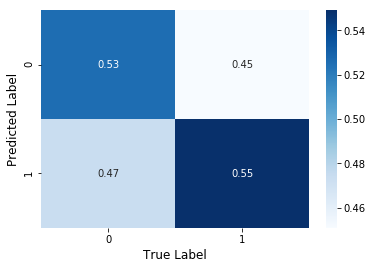

             precision    recall  f1-score   support

          0       0.54      0.53      0.53      7083
          1       0.54      0.55      0.54      7083

avg / total       0.54      0.54      0.54     14166



In [28]:
report, cm = model_acc(lr_y_test_pred, y_test[:,0])
print(report)

In [29]:
len(lr_y_test_pred)

14166

# 3.5 Calculating Feature Importance for Linear Regr
<a id="3.5"> </a>

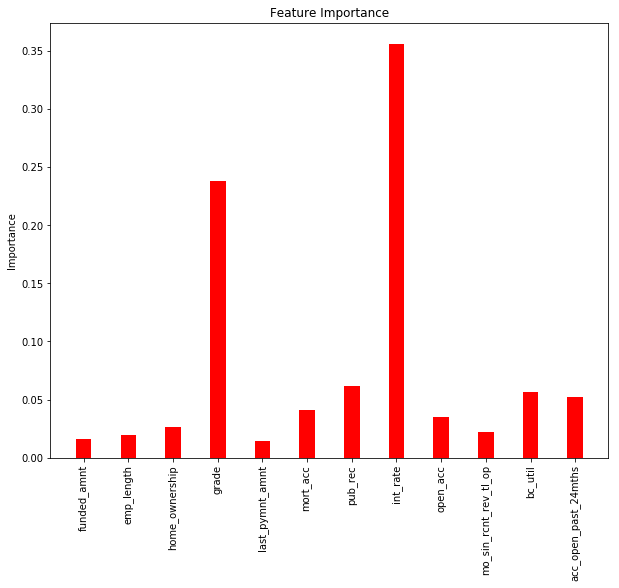

In [30]:
lr_feature_importance = abs(np.std(X_train, 0)*lr.coef_[0])
plot_feat_imp(lr_feature_importance, top_ranked_features)

# 3.6 Logistic Regression with Grid Search
<a id="3.6"> </a>

In [31]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    grid.fit(X,y)
    mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Best accuracy is 0.5121348600149657
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# 4. Model 2: Random Forest
<a id="4"> </a>

Sklear doc:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 4.1 Find the best combinations of hyperparameters
<a id="4.1"> </a>
- Lets use the sklear tool: grid_serach

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,len(top_ranked_features))
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=df[top_ranked_features].values
y=df[target].values
rand.fit(X,y[:,0])
mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [33]:
print(rand.best_estimator_.max_features)

11


## 4.2 Build, Train and Predict
<a id="4.2"> </a>

In [34]:
from sklearn import metrics 
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",
                                      max_features=rand.best_estimator_.max_features,random_state=0,
                                      class_weight="balanced")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
roc_score = metrics.roc_auc_score(y_test,rfPredict)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


# 4.3 Evaluating RF Prediction Accuracy
<a id="4.3"> </a>

             precision    recall  f1-score   support

          0       0.66      0.71      0.68      7083
          1       0.69      0.63      0.66      7083

avg / total       0.67      0.67      0.67     14166



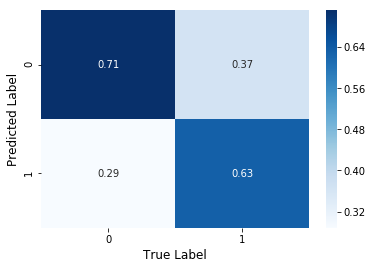

In [35]:
report, cm = model_acc(rfPredict, y_test[:,0])

In [36]:
X_test.shape

(14166, 12)

# 4.4 Plotting Feature importance for RF
<a id="4.4"> </a>

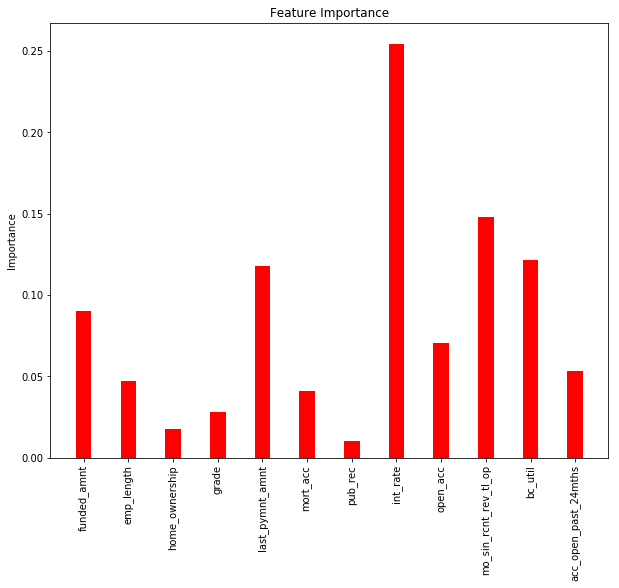

In [37]:
plot_feat_imp(randomForest.feature_importances_, top_ranked_features)

# 5. Model 3: Gradient Boosting
<a id="5"> </a>

You can use different versions of the algorithm:
- https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
- https://lightgbm.readthedocs.io/en/latest/

# 5.1 Build, Train and Predict
<a id="5.1"> </a>

In [38]:
lgb=LGBMClassifier(random_state=51, class_weight= {0: 1, 1: 1.6}, colsample_bytree=1, max_depth=7,
                   min_child_samples=20, min_split_gain=0, n_estimators=100, reg_alpha=13)
lgb.fit(X_train,y_train)
lgb_y_test_pred =lgb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 5.2 Evaluating GB Prediction Accuracy
<a id="5.2"> </a>

             precision    recall  f1-score   support

          0       0.71      0.79      0.75      7083
          1       0.76      0.68      0.72      7083

avg / total       0.74      0.73      0.73     14166



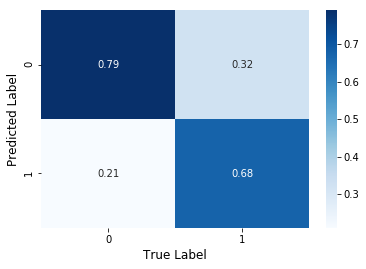

In [39]:
report, cm = model_acc(lgb_y_test_pred, y_test[:,0])

# 5.3 Calculating Feature Importance for GB
<a id="5.3"> </a>

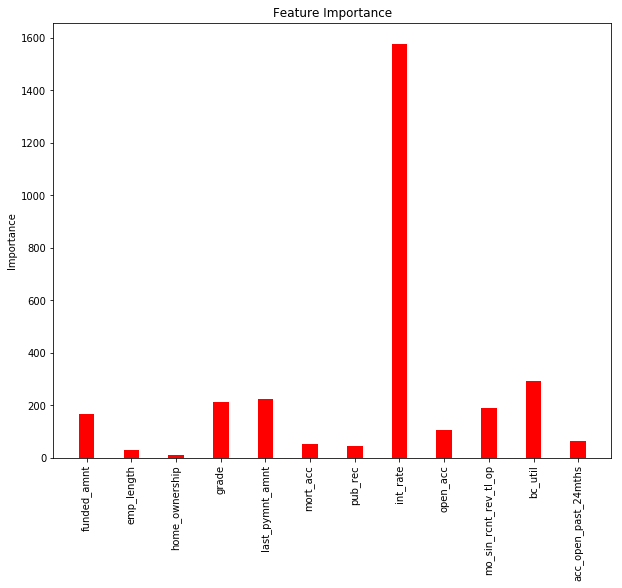

In [42]:
plot_feat_imp(lgb.feature_importances_, top_ranked_features)